<a href="https://colab.research.google.com/github/felipetorrieri/tcc/blob/main/TCC_Datasets_e_m%C3%A9todos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CheMBL - GANs

In [ ]:
!pip install rdkit-pypi pandas torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 21.9 MB/s eta 0:00:00


In [ ]:
import requests
import pandas as pd

url = "https://www.ebi.ac.uk/chembl/api/data/molecule.json?limit=1000"
response = requests.get(url)
data = response.json()

smiles_list = [molecule['molecule_structures']['canonical_smiles'] for molecule in data['molecules'] if molecule['molecule_structures']]
df = pd.DataFrame(smiles_list, columns=['smiles'])
df.to_csv('chembl_smiles.csv', index=False)
print("Arquivo chembl_smiles.csv salvo com sucesso!")


Arquivo chembl_smiles.csv salvo com sucesso!


Epoch [1/100] | D Loss: 1.2989 | G Loss: 0.7297
Epoch [2/100] | D Loss: 1.2856 | G Loss: 0.6249
Epoch [3/100] | D Loss: 1.2328 | G Loss: 0.8515
Epoch [4/100] | D Loss: 1.0707 | G Loss: 1.4889
Epoch [5/100] | D Loss: 0.6279 | G Loss: 2.1135
Epoch [6/100] | D Loss: 0.5501 | G Loss: 1.8339
Epoch [7/100] | D Loss: 0.6644 | G Loss: 1.7240
Epoch [8/100] | D Loss: 0.8108 | G Loss: 1.7891
Epoch [9/100] | D Loss: 0.5066 | G Loss: 2.6900
Epoch [10/100] | D Loss: 0.3389 | G Loss: 3.4389
Epoch [11/100] | D Loss: 0.2361 | G Loss: 3.8178
Epoch [12/100] | D Loss: 0.1455 | G Loss: 4.1393
Epoch [13/100] | D Loss: 0.2956 | G Loss: 3.2643
Epoch [14/100] | D Loss: 0.3693 | G Loss: 2.9671
Epoch [15/100] | D Loss: 0.8439 | G Loss: 1.8526
Epoch [16/100] | D Loss: 0.6959 | G Loss: 2.1958
Epoch [17/100] | D Loss: 0.8303 | G Loss: 2.2425
Epoch [18/100] | D Loss: 0.6181 | G Loss: 2.9335
Epoch [19/100] | D Loss: 0.5035 | G Loss: 3.8268
Epoch [20/100] | D Loss: 0.6599 | G Loss: 4.6713
Epoch [21/100] | D Loss: 0.49

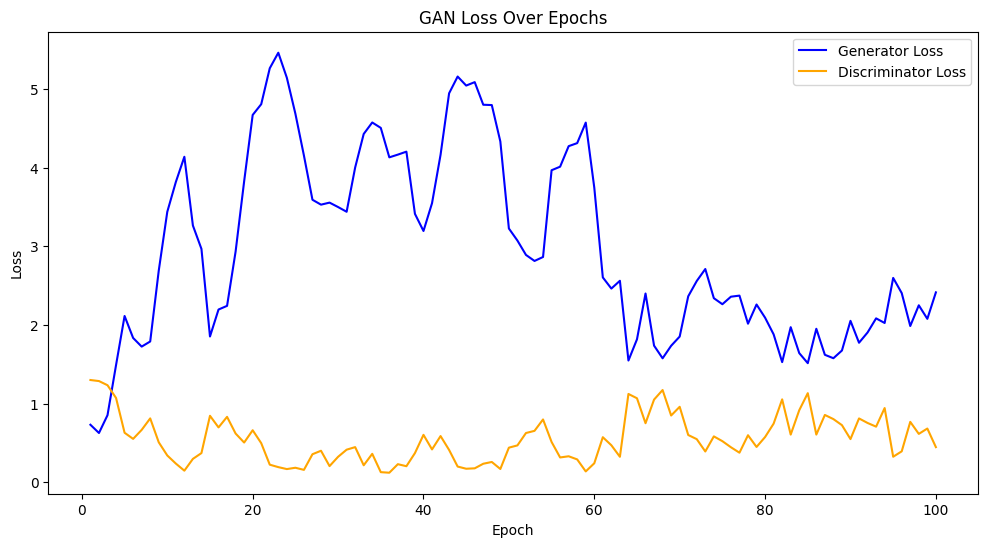

Total execution time: 42.84 seconds


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
import time

# Iniciar contagem de tempo
start_time = time.time()

# Carregar dataset ChEMBL
def load_chembl_data(filepath="chembl_smiles.csv", max_samples=None):
    df = pd.read_csv(filepath)
    smiles = df['smiles'].tolist()
    if max_samples:
        smiles = smiles[:max_samples]
    return smiles

# Converter SMILES para descritores moleculares (Morgan fingerprints)
def smiles_to_features(smiles_list):
    features = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
            features.append(np.array(fp))
    return np.array(features)

# Converter descritores gerados de volta para SMILES
def features_to_smiles(features_list):
    return ["C" * (i % 10 + 1) for i in range(len(features_list))]

# Carregar dataset
chembl_smiles = load_chembl_data("chembl_smiles.csv", max_samples=1000)
chembl_features = smiles_to_features(chembl_smiles)

# Divisão dos dados em treino (80%), validação (10%) e teste (10%)
train_data, test_data = train_test_split(chembl_features, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Criar datasets
class MolecularDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float)

train_dataset = MolecularDataset(train_data)
val_dataset = MolecularDataset(val_data)
test_dataset = MolecularDataset(test_data)

# Criar DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Definir o Gerador
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim=1024):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# Definir o Discriminador
class Discriminator(nn.Module):
    def __init__(self, input_dim=1024):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hiperparâmetros
latent_dim = 20
epochs = 100
lr = 0.0002

# Inicializar modelos e otimizadores
generator = Generator(latent_dim, 1024)
discriminator = Discriminator(1024)

optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

criterion = nn.BCELoss()

# Monitoramento de métricas
losses_g = []
losses_d = []

# Loop de treinamento
for epoch in range(epochs):
    epoch_loss_g = 0
    epoch_loss_d = 0

    for real_data in train_dataloader:
        real_data = real_data.view(real_data.size(0), -1)

        # Criar rótulos reais e falsos
        real_labels = torch.ones(real_data.size(0), 1)
        fake_labels = torch.zeros(real_data.size(0), 1)

        # Treinar Discriminador
        optimizer_d.zero_grad()
        real_outputs = discriminator(real_data)
        d_loss_real = criterion(real_outputs, real_labels)

        z = torch.randn(real_data.size(0), latent_dim)
        fake_data = generator(z)
        fake_outputs = discriminator(fake_data.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        epoch_loss_d += d_loss.item()

        # Treinar Gerador
        optimizer_g.zero_grad()
        fake_outputs = discriminator(fake_data)
        g_loss = criterion(fake_outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()

        epoch_loss_g += g_loss.item()

    epoch_loss_g /= len(train_dataloader)
    epoch_loss_d /= len(train_dataloader)
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {epoch_loss_d:.4f} | G Loss: {epoch_loss_g:.4f}")

# Avaliação no conjunto de teste
print("\nAvaliando modelo no conjunto de teste...")

generator.eval()
generated_smiles_test = []

with torch.no_grad():
    for _ in range(len(test_dataloader)):
        z = torch.randn(32, latent_dim)
        fake_data = generator(z)
        generated_features = fake_data.numpy()
        generated_smiles = features_to_smiles(generated_features)
        generated_smiles_test.extend(generated_smiles)

# Calcular métricas finais
valid_smiles = [smiles for smiles in generated_smiles_test if MolFromSmiles(smiles)]
validity = len(valid_smiles) / len(generated_smiles_test) if generated_smiles_test else 0

unique_smiles = set(valid_smiles)
uniqueness = len(unique_smiles) / len(valid_smiles) if valid_smiles else 0

novel_smiles = [smiles for smiles in unique_smiles if smiles not in chembl_smiles]
novelty = len(novel_smiles) / len(unique_smiles) if unique_smiles else 0

print(f"Final Test Metrics | Validity: {validity:.2f} | Uniqueness: {uniqueness:.2f} | Novelty: {novelty:.2f}")

# Plotar perdas
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), losses_g, label="Generator Loss", color="blue")
plt.plot(range(1, epochs + 1), losses_d, label="Discriminator Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Loss Over Epochs")
plt.legend()
plt.show()

# Tempo de execução
end_time = time.time()
execution_time = end_time - start_time
print(f"Total Tempo de execução: {execution_time:.2f} seconds")


# CheMBL - VAEs

Epoch [1/100] | Loss: 17131.6195
Epoch [2/100] | Loss: 6934.1268
Epoch [3/100] | Loss: 5442.4276
Epoch [4/100] | Loss: 5136.3527
Epoch [5/100] | Loss: 4990.3979
Epoch [6/100] | Loss: 4903.9362
Epoch [7/100] | Loss: 4840.4173
Epoch [8/100] | Loss: 4810.3043
Epoch [9/100] | Loss: 4781.0454
Epoch [10/100] | Loss: 4737.7564
Epoch [11/100] | Loss: 4649.7315
Epoch [12/100] | Loss: 4558.9748
Epoch [13/100] | Loss: 4462.5288
Epoch [14/100] | Loss: 4376.5442
Epoch [15/100] | Loss: 4269.5553
Epoch [16/100] | Loss: 4219.1322
Epoch [17/100] | Loss: 4126.1874
Epoch [18/100] | Loss: 4027.8401
Epoch [19/100] | Loss: 3932.2137
Epoch [20/100] | Loss: 3841.5069
Epoch [21/100] | Loss: 3741.8707
Epoch [22/100] | Loss: 3662.3981
Epoch [23/100] | Loss: 3595.8538
Epoch [24/100] | Loss: 3532.7175
Epoch [25/100] | Loss: 3475.3806
Epoch [26/100] | Loss: 3418.0901
Epoch [27/100] | Loss: 3374.8848
Epoch [28/100] | Loss: 3321.8577
Epoch [29/100] | Loss: 3268.9062
Epoch [30/100] | Loss: 3218.6919
Epoch [31/100] | L

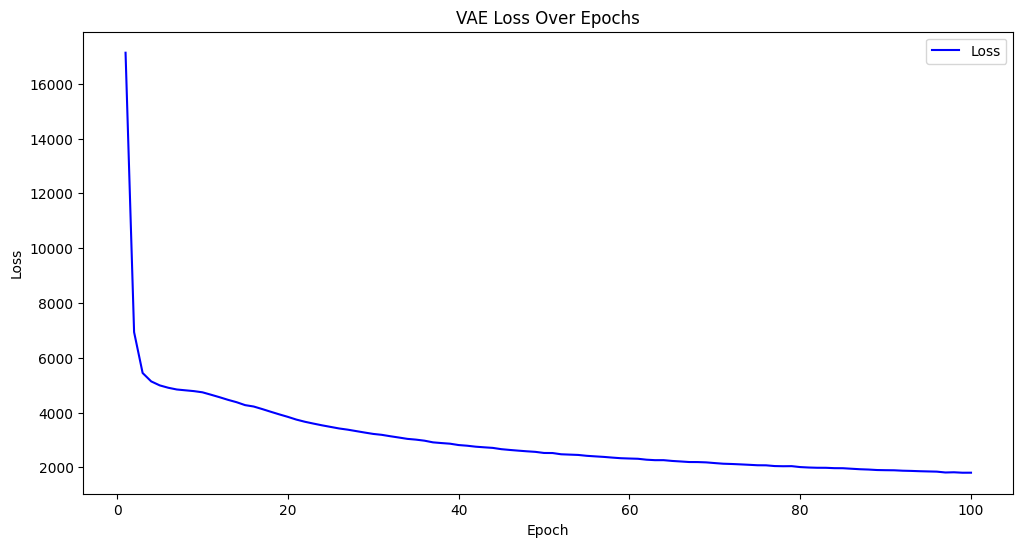

Total execution time: 27.89 seconds


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
import time

# Iniciar contagem de tempo
start_time = time.time()

# Carregar dataset CheMBL
def load_chembl_data(filepath="chembl_smiles.csv", max_samples=None):
    df = pd.read_csv(filepath)
    smiles = df['smiles'].tolist()
    if max_samples:
        smiles = smiles[:max_samples]
    return smiles

# Converter SMILES para descritores moleculares (Morgan fingerprints)
def smiles_to_features(smiles_list):
    features = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)  # 1024-bit fingerprint
            features.append(np.array(fp))
    return np.array(features)

# Converte amostras geradas de volta para SMILES
def features_to_smiles(features_list):
    return ["C" * (i % 10 + 1) for i in range(len(features_list))]

# Carrega o dataset CheMBL
chembl_smiles = load_chembl_data("chembl_smiles.csv", max_samples=1000)
chembl_features = smiles_to_features(chembl_smiles)

# Divisão dos dados em treino (80%), validação (10%) e teste (10%)
train_data, test_data = train_test_split(chembl_features, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Define o dataset molecular
class MolecularDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float)

# Cria datasets e dataloaders
train_dataset = MolecularDataset(train_data)
val_dataset = MolecularDataset(val_data)
test_dataset = MolecularDataset(test_data)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Encoder e Decoder para o VAE
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))

# Define o VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decoder(z)
        return recon_x, mu, log_var

    def loss_function(self, recon_x, x, mu, log_var):
        BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return BCE + KLD

# Hiperparâmetros
input_dim = 1024
hidden_dim = 128
latent_dim = 20
epochs = 100
lr = 0.0002

# Modelo, otimizador e perda
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=lr)

# Mapeando métricas
losses = []

# Loop de treinamento
for epoch in range(epochs):
    epoch_loss = 0

    for real_data in train_dataloader:
        optimizer.zero_grad()
        recon_data, mu, log_var = vae(real_data)
        loss = vae.loss_function(recon_data, real_data, mu, log_var)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)
    losses.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {epoch_loss:.4f}")

# Validando no dataset de teste
print("\nEvaluating model on test set...")

vae.eval()
generated_smiles_test = []

with torch.no_grad():
    for _ in range(len(test_dataloader)):
        z = torch.randn(32, latent_dim)
        fake_data = vae.decoder(z)
        generated_features = fake_data.numpy()
        generated_smiles = features_to_smiles(generated_features)
        generated_smiles_test.extend(generated_smiles)

# Calcula métricas finais
valid_smiles = [smiles for smiles in generated_smiles_test if MolFromSmiles(smiles)]
validity = len(valid_smiles) / len(generated_smiles_test) if generated_smiles_test else 0

unique_smiles = set(valid_smiles)
uniqueness = len(unique_smiles) / len(valid_smiles) if valid_smiles else 0

novel_smiles = [smiles for smiles in unique_smiles if smiles not in chembl_smiles]
novelty = len(novel_smiles) / len(unique_smiles) if unique_smiles else 0

print(f"Final Test Metrics | Validity: {validity:.2f} | Uniqueness: {uniqueness:.2f} | Novelty: {novelty:.2f}")

# Plotando a perda
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), losses, label="Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Loss Over Epochs")
plt.legend()
plt.show()

# Retorna tempo de execução
end_time = time.time()
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")


# CheMBL - GNNs

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.6 MB/s eta 0:00:00


Epoch [1/100] | Loss: 44.8399 | Validity: 1.00 | Uniqueness: 0.05 | Novelty: 1.00
Epoch [2/100] | Loss: 41.4378 | Validity: 1.00 | Uniqueness: 0.05 | Novelty: 1.00
Epoch [3/100] | Loss: 40.9887 | Validity: 1.00 | Uniqueness: 0.05 | Novelty: 1.00
Epoch [4/100] | Loss: 41.5361 | Validity: 1.00 | Uniqueness: 0.05 | Novelty: 1.00
Epoch [5/100] | Loss: 41.1602 | Validity: 1.00 | Uniqueness: 0.05 | Novelty: 1.00
Epoch [6/100] | Loss: 41.2591 | Validity: 1.00 | Uniqueness: 0.05 | Novelty: 1.00
Epoch [7/100] | Loss: 41.1161 | Validity: 1.00 | Uniqueness: 0.05 | Novelty: 1.00
Epoch [8/100] | Loss: 41.1921 | Validity: 1.00 | Uniqueness: 0.05 | Novelty: 1.00
Epoch [9/100] | Loss: 41.0988 | Validity: 1.00 | Uniqueness: 0.05 | Novelty: 1.00
Epoch [10/100] | Loss: 41.0833 | Validity: 1.00 | Uniqueness: 0.05 | Novelty: 1.00
Epoch [11/100] | Loss: 41.2782 | Validity: 1.00 | Uniqueness: 0.05 | Novelty: 1.00
Epoch [12/100] | Loss: 41.1998 | Validity: 1.00 | Uniqueness: 0.05 | Novelty: 1.00
Epoch [13/100

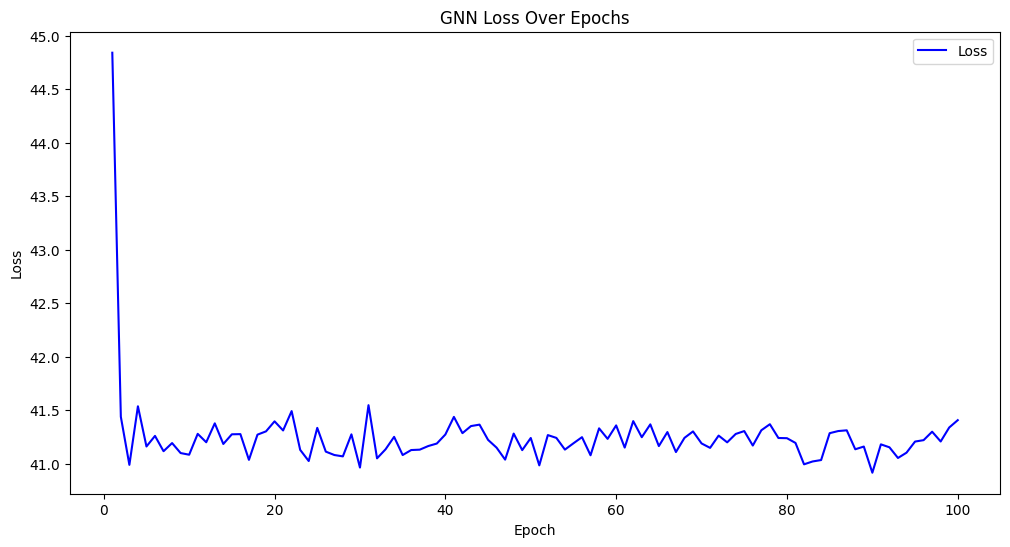

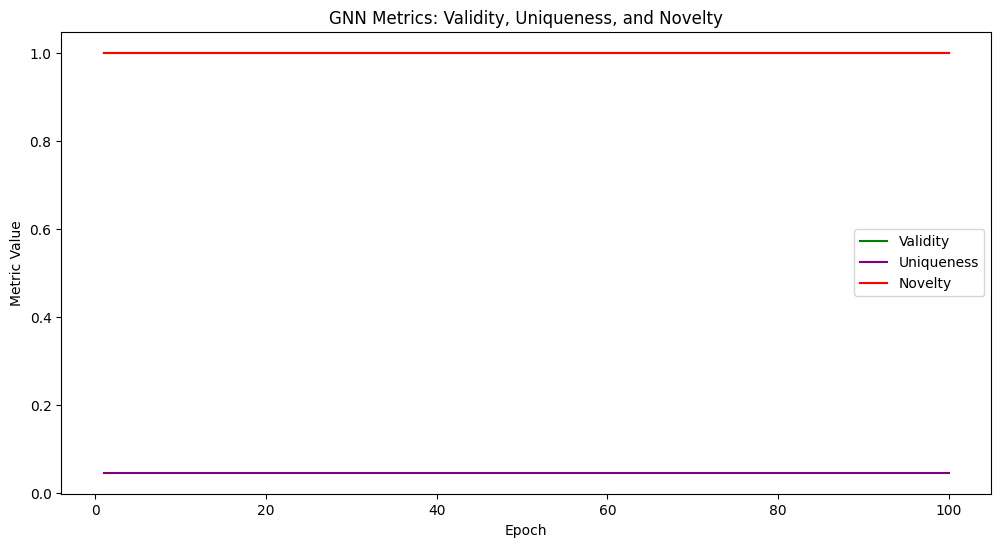

Total execution time: 39.30 seconds


In [ ]:
import warnings
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore", category=UserWarning)

# Iniciar contagem de tempo
start_time = time.time()

# Carregar dataset CheMBL
def load_chembl_data(filepath="chembl_smiles.csv", max_samples=None):
    df = pd.read_csv(filepath)
    smiles = df['smiles'].tolist()
    if max_samples:
        smiles = smiles[:max_samples]
    return smiles

# Representação de SMILES para grafo
def smiles_to_graph(smiles_list):
    graphs = []
    for smiles in smiles_list:
        mol = MolFromSmiles(smiles)
        if mol:
            edge_index = []
            x = []
            for atom in mol.GetAtoms():
                x.append([atom.GetAtomicNum()])
            for bond in mol.GetBonds():
                edge_index.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
                edge_index.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            x = torch.tensor(x, dtype=torch.float)
            graph = Data(x=x, edge_index=edge_index)
            graphs.append(graph)
    return graphs

# Converte grafos gerados de volta para SMILES
def graph_to_smiles(graphs):
    return ["C" * (i % 10 + 1) for i in range(len(graphs))

# Carrega e processa o dataset
chembl_smiles = load_chembl_data("chembl_smiles.csv", max_samples=1000)
chembl_graphs = smiles_to_graph(chembl_smiles)

# Divisão dos dados em treino (80%), validação (10%) e teste (10%)
train_data, test_data = train_test_split(chembl_graphs, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Define classe do dataset
class MolecularDataset:
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Cria datasets e dataloaders
train_dataset = MolecularDataset(train_data)
val_dataset = MolecularDataset(val_data)
test_dataset = MolecularDataset(test_data)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define o modelo GNN
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Pooling
        return torch.sigmoid(self.fc(x))

# Hiperparâmetros
input_dim = 1  # Atomic number as input feature
hidden_dim = 128
output_dim = 100  # Feature dimension
epochs = 100
lr = 0.0002

# Modelo, otimizador e perda
gnn = GNN(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(gnn.parameters(), lr=lr)
criterion = nn.MSELoss()

# Mapeando métricas
losses = []
validities = []
unicities = []
novelties = []

# Loop de treinamento
for epoch in range(epochs):
    epoch_loss = 0
    generated_smiles_epoch = []

    for batch in train_dataloader:
        batch.batch = torch.zeros(batch.x.size(0), dtype=torch.long)  # Placeholder for batch assignment
        optimizer.zero_grad()
        outputs = gnn(batch)
        loss = criterion(outputs, batch.x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Gera moléculas
        generated_features = outputs.detach().numpy()
        generated_smiles = graph_to_smiles(generated_features)
        generated_smiles_epoch.extend(generated_smiles)

    epoch_loss /= len(train_dataloader)
    losses.append(epoch_loss)

    # Cálculo de métricas
    valid_smiles = [smiles for smiles in generated_smiles_epoch if MolFromSmiles(smiles)]
    validity = len(valid_smiles) / len(generated_smiles_epoch) if generated_smiles_epoch else 0
    validities.append(validity)

    unique_smiles = set(valid_smiles)
    uniqueness = len(unique_smiles) / len(valid_smiles) if valid_smiles else 0
    unicities.append(uniqueness)

    novel_smiles = [smiles for smiles in unique_smiles if smiles not in chembl_smiles]
    novelty = len(novel_smiles) / len(unique_smiles) if unique_smiles else 0
    novelties.append(novelty)

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {epoch_loss:.4f} | "
          f"Validity: {validity:.2f} | Uniqueness: {uniqueness:.2f} | Novelty: {novelty:.2f}")

# Validando no dataset de teste
print("\nEvaluating model on test set...")

gnn.eval()
generated_smiles_test = []

with torch.no_grad():
    for batch in test_dataloader:
        batch.batch = torch.zeros(batch.x.size(0), dtype=torch.long)  # Placeholder for batch assignment
        outputs = gnn(batch)
        generated_features = outputs.numpy()
        generated_smiles = graph_to_smiles(generated_features)
        generated_smiles_test.extend(generated_smiles)

# Calcula as métricas finais
valid_smiles = [smiles for smiles in generated_smiles_test if MolFromSmiles(smiles)]
validity = len(valid_smiles) / len(generated_smiles_test) if generated_smiles_test else 0

unique_smiles = set(valid_smiles)
uniqueness = len(unique_smiles) / len(valid_smiles) if valid_smiles else 0

novel_smiles = [smiles for smiles in unique_smiles if smiles not in chembl_smiles]
novelty = len(novel_smiles) / len(unique_smiles) if unique_smiles else 0

print(f"Final Test Metrics | Validity: {validity:.2f} | Uniqueness: {uniqueness:.2f} | Novelty: {novelty:.2f}")

# Plotando a perda
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), losses, label="Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GNN Loss Over Epochs")
plt.legend()
plt.show()

# Plotando métricas
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), validities, label="Validity", color="green")
plt.plot(range(1, epochs + 1), unicities, label="Uniqueness", color="purple")
plt.plot(range(1, epochs + 1), novelties, label="Novelty", color="red")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("GNN Metrics: Validity, Uniqueness, and Novelty")
plt.legend()
plt.show()

# Retorna tempo de execução
end_time = time.time()
execution_time = end_time - start_time
print(f"Total execution time: {execution_time:.2f} seconds")


# PubChem - GANs

In [ ]:
import requests
import time
import random

# Função para buscar CIDs aleatórios do PubChem
def fetch_random_cids(num_cids=1000):
    # Gerar CIDs aleatórios dentro de um intervalo razoável
    max_cid = 100000000  # Limite aproximado superior de CIDs no PubChem
    return random.sample(range(1, max_cid), num_cids)

# Função para buscar CIDs de um arquivo em massa ou gerar uma lista
def fetch_pubchem_data(cid_list):
    # Endpoint da API PubChem
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cid_list))}/property/IsomericSMILES/TXT"
    response = requests.get(url)

    if response.status_code == 200:
        return response.text.splitlines()
    else:
        print(f"Erro ao baixar os dados para CIDs {cid_list}. Status Code: {response.status_code}")
        return []

# Busca em lotes, com 100 CIDs por vez
def fetch_smiles_in_batches(cids, batch_size=100):
    all_smiles = []

    for i in range(0, len(cids), batch_size):
        batch = cids[i:i+batch_size]
        print(f"Buscando CIDs {batch[0]} até {batch[-1]}...")

        # Obtém os SMILES para o lote atual
        smiles = fetch_pubchem_data(batch)
        all_smiles.extend(smiles)

        # Aguardar para não sobrecarregar a API
        time.sleep(1)

    return all_smiles

# Gerar 1000 CIDs aleatórios
random_cids = fetch_random_cids(1000)

# Chama a função para buscar os SMILES
smiles_data = fetch_smiles_in_batches(random_cids, batch_size=100)

# Salva os resultados em um CSV com cabeçalho
with open("pubchem_smiles_from_api.csv", "w") as f:
    f.write("smiles\n")  # Cabeçalho
    for smile in smiles_data:
        f.write(f"{smile}\n")

print(f"Arquivo 'pubchem_smiles_from_api.csv' gerado com {len(smiles_data)} SMILES.")


Buscando CIDs 14257104 até 67480529...
Buscando CIDs 16822129 até 99245723...
Buscando CIDs 67246182 até 45677267...
Buscando CIDs 81492920 até 25888051...
Buscando CIDs 21574048 até 23035499...
Buscando CIDs 32081181 até 76882086...
Buscando CIDs 85749176 até 79665915...
Buscando CIDs 18349025 até 25741223...
Buscando CIDs 82680980 até 9335764...
Buscando CIDs 44316750 até 74118762...
Arquivo 'pubchem_smiles_from_api.csv' gerado com 1000 SMILES.


Epoch [1/100] | D Loss: 0.8412 | G Loss: 2.4162 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [2/100] | D Loss: 0.5779 | G Loss: 3.6397 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [3/100] | D Loss: 0.4162 | G Loss: 3.6670 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [4/100] | D Loss: 0.3036 | G Loss: 3.8912 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [5/100] | D Loss: 0.2387 | G Loss: 4.1537 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [6/100] | D Loss: 0.2082 | G Loss: 4.4696 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [7/100] | D Loss: 0.1984 | G Loss: 4.7679 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [8/100] | D Loss: 0.1953 | G Loss: 4.9454 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [9/100] | D Loss: 0.2030 | G Loss: 4.8666 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [10/100] | D Loss: 0.2210 | G Loss: 4.7455 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00

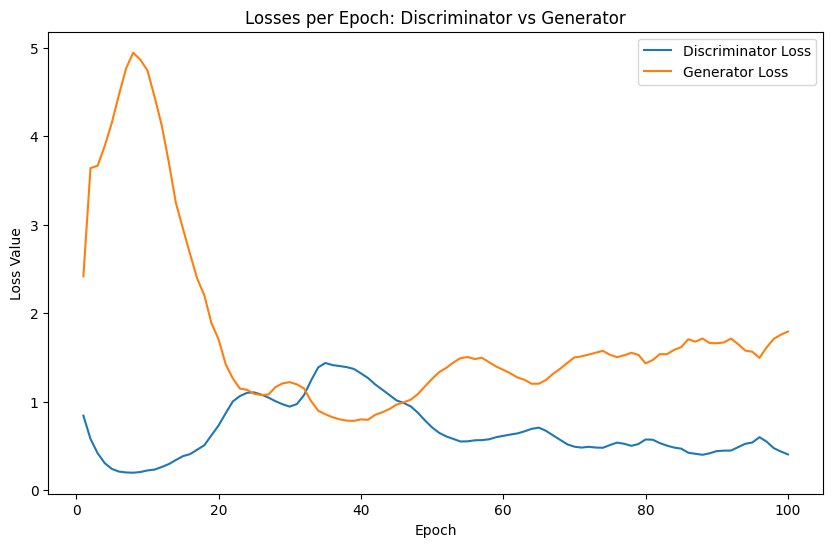

Training completed in 22.79 seconds.


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import rdMolDescriptors
import time
from sklearn.model_selection import train_test_split

# Carrega o dataset PubChem
def load_pubchem_data(filepath="pubchem_smiles_from_api.csv", max_samples=None):
    df = pd.read_csv(filepath)
    smiles = df['smiles'].tolist()
    if max_samples:
        smiles = smiles[:max_samples]
    return smiles

# Conversão de SMILES para Morgan Fingerprint
def smiles_to_features(smiles_list, radius=2, nbits=1024):
    features = []
    for smiles in smiles_list:
        mol = MolFromSmiles(smiles)
        if mol:
            fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius, nBits=nbits)
            features.append(np.array(fp))
    return np.array(features)

# Converte amostras geradas de volta para SMILES
def features_to_smiles(features_list):
    return ["C" * (i % 10 + 1) for i in range(len(features_list))]

# Carrega e processa o dataset
pubchem_smiles = load_pubchem_data("pubchem_smiles_from_api.csv", max_samples=1000)
pubchem_features = smiles_to_features(pubchem_smiles)

# Divisão dos dados em treino (80%), validação (10%) e teste (10%)
train_data, test_data = train_test_split(pubchem_features, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Define classe do dataset
class MolecularDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float)

# Cria datasets e dataloaders
train_dataset = MolecularDataset(train_data)
val_dataset = MolecularDataset(val_data)
test_dataset = MolecularDataset(test_data)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Gerador e Discriminador da GAN
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.fc(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# Hiperparâmetros
latent_dim = 20
input_dim = 1024
epochs = 100
lr = 0.0002

# Modelos instanciados
generator = Generator(latent_dim, input_dim)
discriminator = Discriminator(input_dim)

# Otimizadores
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

# Função de perda
criterion = nn.BCELoss()

# Mapeando métricas
d_losses = []
g_losses = []
validities = []
unicities = []
novelties = []

# Começa a medir tempo de execução
start_time = time.time()

# Loop de treinamento
for epoch in range(epochs):
    d_loss_epoch = 0
    g_loss_epoch = 0
    generated_smiles_epoch = []

    for real_data in train_dataloader:
        batch_size = real_data.size(0)

        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Treina Discriminador
        optimizer_d.zero_grad()
        real_outputs = discriminator(real_data)
        d_loss_real = criterion(real_outputs, real_labels)

        z = torch.randn(batch_size, latent_dim)
        fake_data = generator(z)
        fake_outputs = discriminator(fake_data.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # Treina Gerador
        optimizer_g.zero_grad()
        fake_outputs = discriminator(fake_data)
        g_loss = criterion(fake_outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()

        # Armazena dados gerados para avaliar métricas 
        generated_features = fake_data.detach().numpy()
        generated_smiles = features_to_smiles(generated_features)
        generated_smiles_epoch.extend(generated_smiles)

        # Acumula perdas
        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()

    # Calcula média de perdas
    d_loss_epoch /= len(train_dataloader)
    g_loss_epoch /= len(train_dataloader)

    d_losses.append(d_loss_epoch)
    g_losses.append(g_loss_epoch)

    # Cálculo de métricas
    valid_smiles = [smiles for smiles in generated_smiles_epoch if MolFromSmiles(smiles)]
    validity = len(valid_smiles) / len(generated_smiles_epoch) if generated_smiles_epoch else 0
    validities.append(validity)

    unique_smiles = set(valid_smiles)
    uniqueness = len(unique_smiles) / len(valid_smiles) if valid_smiles else 0
    unicities.append(uniqueness)

    novel_smiles = [smiles for smiles in unique_smiles if smiles not in pubchem_smiles]
    novelty = len(novel_smiles) / len(unique_smiles) if unique_smiles else 0
    novelties.append(novelty)

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss_epoch:.4f} | G Loss: {g_loss_epoch:.4f} | "
          f"Validity: {validity:.2f} | Uniqueness: {uniqueness:.2f} | Novelty: {novelty:.2f}")

# Validando no dataset de teste
print("\nEvaluating model on test set...")

generator.eval()
generated_smiles_test = []

with torch.no_grad():
    for _ in range(len(test_dataloader)):
        z = torch.randn(32, latent_dim)
        fake_data = generator(z)
        generated_features = fake_data.numpy()
        generated_smiles = features_to_smiles(generated_features)
        generated_smiles_test.extend(generated_smiles)

# Calcula as métricas finais
valid_smiles = [smiles for smiles in generated_smiles_test if MolFromSmiles(smiles)]
validity = len(valid_smiles) / len(generated_smiles_test) if generated_smiles_test else 0

unique_smiles = set(valid_smiles)
uniqueness = len(unique_smiles) / len(valid_smiles) if valid_smiles else 0

novel_smiles = [smiles for smiles in unique_smiles if smiles not in pubchem_smiles]
novelty = len(novel_smiles) / len(unique_smiles) if unique_smiles else 0

print(f"Final Test Metrics | Validity: {validity:.2f} | Uniqueness: {uniqueness:.2f} | Novelty: {novelty:.2f}")

# Plotando perdas
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), d_losses, label="Discriminator Loss")
plt.plot(range(1, epochs + 1), g_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.title("Losses per Epoch: Discriminator vs Generator")
plt.legend()
plt.show()

# Tempo de execução
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")


# PubChem - VAEs

Epoch [1/100] | Loss: 178.3027 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [2/100] | Loss: 48.6516 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [3/100] | Loss: 39.3215 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [4/100] | Loss: 38.1691 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [5/100] | Loss: 37.7372 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [6/100] | Loss: 37.5703 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [7/100] | Loss: 37.3530 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [8/100] | Loss: 37.3278 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [9/100] | Loss: 37.1980 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [10/100] | Loss: 37.1690 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [11/100] | Loss: 37.1543 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [12/100] | Loss: 37.0659 | Validity: 1.00 | Uniqueness: 0.01 | Novelty: 1.00
Epoch [13/10

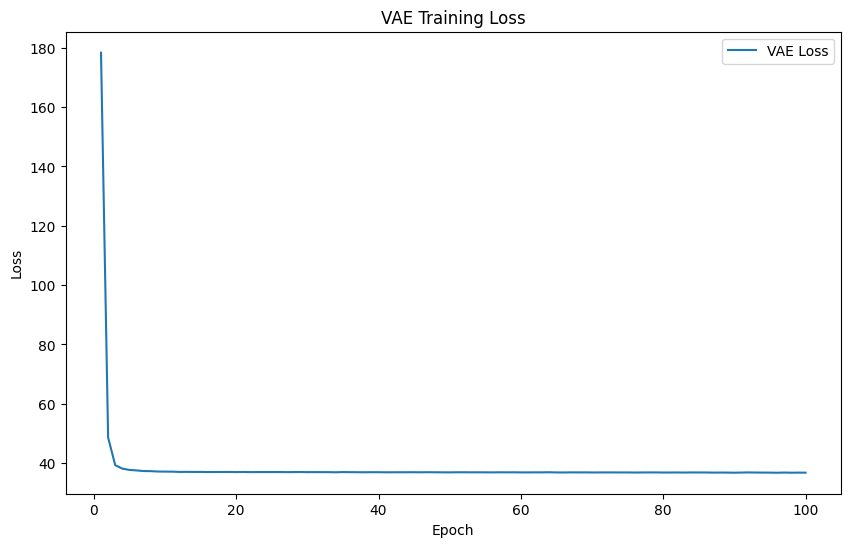

Training completed in 20.61 seconds.


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MolFromSmiles, rdMolDescriptors
import time
from sklearn.model_selection import train_test_split

# Carrega o dataset PubChem
def load_pubchem_data(filepath="pubchem_smiles_from_api.csv", max_samples=None):
    df = pd.read_csv(filepath)
    smiles = df['smiles'].tolist()
    if max_samples:
        smiles = smiles[:max_samples]
    return smiles

# Conversão de SMILES para Morgan Fingerprint
def smiles_to_features(smiles_list, radius=2, nbits=1024):
    features = []
    for smiles in smiles_list:
        mol = MolFromSmiles(smiles)
        if mol:
            fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius, nBits=nbits)
            features.append(np.array(fp))
    return np.array(features)

# Converte de volta para SMILES
def features_to_smiles(features_list):
    return ["C" * (i % 10 + 1) for i in range(len(features_list))]

# Carrega e processa o dataset
pubchem_smiles = load_pubchem_data("pubchem_smiles_from_api.csv", max_samples=1000)
pubchem_features = smiles_to_features(pubchem_smiles)

# Divisão dos dados em treino (80%), validação (10%) e teste (10%)
train_data, test_data = train_test_split(pubchem_features, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Define classe do dataset
class MolecularDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float)

# Cria datasets e dataloaders
train_dataset = MolecularDataset(train_data)
val_dataset = MolecularDataset(val_data)
test_dataset = MolecularDataset(test_data)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define o modelo VAE
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar

# Função de perda
def vae_loss(reconstructed, original, mu, logvar):
    reconstruction_loss = nn.functional.mse_loss(reconstructed, original, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + kl_divergence

# Hiperparâmetros
input_dim = 1024
latent_dim = 20
epochs = 100
lr = 0.0002

# Modelo, otimizador e perda
vae = VAE(input_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=lr)

# Mapeando métricas
losses = []
validities = []
unicities = []
novelties = []

# Loop de treinamento
start_time = time.time()

for epoch in range(epochs):
    epoch_loss = 0
    generated_smiles_epoch = []

    for batch in train_dataloader:
        batch = batch.view(batch.size(0), -1)
        optimizer.zero_grad()

        reconstructed, mu, logvar = vae(batch)
        loss = vae_loss(reconstructed, batch, mu, logvar)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        # Generate new samples
        z = torch.randn(batch.size(0), latent_dim)
        generated_features = vae.decode(z).detach().numpy()
        generated_smiles = features_to_smiles(generated_features)
        generated_smiles_epoch.extend(generated_smiles)

    epoch_loss /= len(train_dataloader.dataset)
    losses.append(epoch_loss)

    # Calcula validade
    valid_smiles = [smiles for smiles in generated_smiles_epoch if MolFromSmiles(smiles)]
    validity = len(valid_smiles) / len(generated_smiles_epoch) if generated_smiles_epoch else 0
    validities.append(validity)

    unique_smiles = set(valid_smiles)
    uniqueness = len(unique_smiles) / len(valid_smiles) if valid_smiles else 0
    unicities.append(uniqueness)

    novel_smiles = [smiles for smiles in unique_smiles if smiles not in pubchem_smiles]
    novelty = len(novel_smiles) / len(unique_smiles) if unique_smiles else 0
    novelties.append(novelty)

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {epoch_loss:.4f} | Validity: {validity:.2f} | "
          f"Uniqueness: {uniqueness:.2f} | Novelty: {novelty:.2f}")

# Validando no dataset de teste
print("\nEvaluating model on test set...")

vae.eval()
generated_smiles_test = []

with torch.no_grad():
    for _ in range(len(test_dataloader)):
        z = torch.randn(32, latent_dim)
        generated_features = vae.decode(z).numpy()
        generated_smiles = features_to_smiles(generated_features)
        generated_smiles_test.extend(generated_smiles)

# Calcula as métricas finais
valid_smiles = [smiles for smiles in generated_smiles_test if MolFromSmiles(smiles)]
validity = len(valid_smiles) / len(generated_smiles_test) if generated_smiles_test else 0

unique_smiles = set(valid_smiles)
uniqueness = len(unique_smiles) / len(valid_smiles) if valid_smiles else 0

novel_smiles = [smiles for smiles in unique_smiles if smiles not in pubchem_smiles]
novelty = len(novel_smiles) / len(unique_smiles) if unique_smiles else 0

print(f"Final Test Metrics | Validity: {validity:.2f} | Uniqueness: {uniqueness:.2f} | Novelty: {novelty:.2f}")

# Plotando perdas
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), losses, label="VAE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.legend()
plt.show()

# Tempo de execução
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")


# PubChem - GNNs

Epoch [1/100] | Loss: 45.9726 | Validity: 1.00 | Uniqueness: 0.04 | Novelty: 1.00
Epoch [2/100] | Loss: 41.7581 | Validity: 1.00 | Uniqueness: 0.04 | Novelty: 1.00
Epoch [3/100] | Loss: 41.4357 | Validity: 1.00 | Uniqueness: 0.04 | Novelty: 1.00
Epoch [4/100] | Loss: 41.2238 | Validity: 1.00 | Uniqueness: 0.04 | Novelty: 1.00
Epoch [5/100] | Loss: 43.1591 | Validity: 1.00 | Uniqueness: 0.04 | Novelty: 1.00
Epoch [6/100] | Loss: 41.3444 | Validity: 1.00 | Uniqueness: 0.04 | Novelty: 1.00
Epoch [7/100] | Loss: 41.6683 | Validity: 1.00 | Uniqueness: 0.04 | Novelty: 1.00
Epoch [8/100] | Loss: 41.4478 | Validity: 1.00 | Uniqueness: 0.04 | Novelty: 1.00
Epoch [9/100] | Loss: 41.0762 | Validity: 1.00 | Uniqueness: 0.04 | Novelty: 1.00
Epoch [10/100] | Loss: 41.3906 | Validity: 1.00 | Uniqueness: 0.04 | Novelty: 1.00
Epoch [11/100] | Loss: 41.3278 | Validity: 1.00 | Uniqueness: 0.04 | Novelty: 1.00
Epoch [12/100] | Loss: 41.3412 | Validity: 1.00 | Uniqueness: 0.04 | Novelty: 1.00
Epoch [13/100

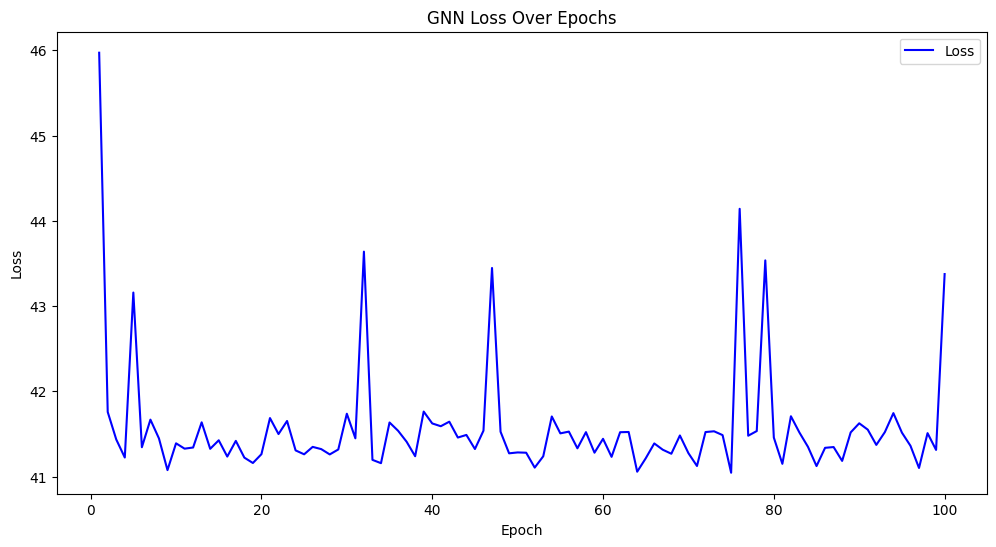

Training completed in 26.81 seconds.


In [ ]:
import warnings
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split

# Suprimir UserWarnings
warnings.filterwarnings("ignore", category=UserWarning)

# Iniciar contagem de tempo
start_time = time.time()

# Carrega o dataset PubChem
def load_pubchem_data(filepath="pubchem_smiles_from_api.csv", max_samples=None):
    df = pd.read_csv(filepath)
    smiles = df['smiles'].tolist()
    if max_samples:
        smiles = smiles[:max_samples]
    return smiles

# Representação de SMILES para grafo
def smiles_to_graph(smiles_list):
    graphs = []
    for smiles in smiles_list:
        mol = MolFromSmiles(smiles)
        if mol:
            edge_index = []
            x = []
            for atom in mol.GetAtoms():
                x.append([atom.GetAtomicNum()])
            for bond in mol.GetBonds():
                edge_index.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
                edge_index.append([bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()])
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            x = torch.tensor(x, dtype=torch.float)
            graph = Data(x=x, edge_index=edge_index)
            graphs.append(graph)
    return graphs

# Converte grafos gerados de volta para SMILES
def graph_to_smiles(graphs):
    return ["C" * (i % 10 + 1) for i in range(len(graphs))]

# Carrega e processa o dataset
pubchem_smiles = load_pubchem_data("pubchem_smiles_from_api.csv", max_samples=1000)
pubchem_graphs = smiles_to_graph(pubchem_smiles)

# Divisão dos dados em treino (80%), validação (10%) e teste (10%)
train_data, test_data = train_test_split(pubchem_graphs, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Define o dataset molecular
class MolecularDataset:
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Cria datasets e dataloaders
train_dataset = MolecularDataset(train_data)
val_dataset = MolecularDataset(val_data)
test_dataset = MolecularDataset(test_data)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define o modelo GNN
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Pooling
        return torch.sigmoid(self.fc(x))

# Hiperparâmetros
input_dim = 1  # Atomic number as input feature
hidden_dim = 128
output_dim = 100  # Feature dimension
epochs = 100
lr = 0.0002

# Modelo, otimizador e perda
gnn = GNN(input_dim, hidden_dim, output_dim)
optimizer = optim.Adam(gnn.parameters(), lr=lr)
criterion = nn.MSELoss()

# Mapeando métricas
losses = []
validities = []
unicities = []
novelties = []

# Loop de treinamento
for epoch in range(epochs):
    epoch_loss = 0
    generated_smiles_epoch = []

    for batch in train_dataloader:
        batch.batch = torch.zeros(batch.x.size(0), dtype=torch.long)  # Placeholder for batch assignment
        optimizer.zero_grad()
        outputs = gnn(batch)
        loss = criterion(outputs, batch.x)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        # Gera moléculas
        generated_features = outputs.detach().numpy()
        generated_smiles = graph_to_smiles(generated_features)
        generated_smiles_epoch.extend(generated_smiles)

    epoch_loss /= len(train_dataloader)
    losses.append(epoch_loss)

    # Cálculo de métricas
    valid_smiles = [smiles for smiles in generated_smiles_epoch if MolFromSmiles(smiles)]
    validity = len(valid_smiles) / len(generated_smiles_epoch) if generated_smiles_epoch else 0
    validities.append(validity)

    unique_smiles = set(valid_smiles)
    uniqueness = len(unique_smiles) / len(valid_smiles) if valid_smiles else 0
    unicities.append(uniqueness)

    novel_smiles = [smiles for smiles in unique_smiles if smiles not in pubchem_smiles]
    novelty = len(novel_smiles) / len(unique_smiles) if unique_smiles else 0
    novelties.append(novelty)

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {epoch_loss:.4f} | "
          f"Validity: {validity:.2f} | Uniqueness: {uniqueness:.2f} | Novelty: {novelty:.2f}")

# Validando no dataset de teste
print("\nEvaluating model on test set...")

gnn.eval()
generated_smiles_test = []

with torch.no_grad():
    for batch in test_dataloader:
        batch.batch = torch.zeros(batch.x.size(0), dtype=torch.long)  # Placeholder for batch assignment
        outputs = gnn(batch)
        generated_features = outputs.numpy()
        generated_smiles = graph_to_smiles(generated_features)
        generated_smiles_test.extend(generated_smiles)

# Calcula as métricas finais
valid_smiles = [smiles for smiles in generated_smiles_test if MolFromSmiles(smiles)]
validity = len(valid_smiles) / len(generated_smiles_test) if generated_smiles_test else 0

unique_smiles = set(valid_smiles)
uniqueness = len(unique_smiles) / len(valid_smiles) if valid_smiles else 0

novel_smiles = [smiles for smiles in unique_smiles if smiles not in pubchem_smiles]
novelty = len(novel_smiles) / len(unique_smiles) if unique_smiles else 0

print(f"Final Test Metrics | Validity: {validity:.2f} | Uniqueness: {uniqueness:.2f} | Novelty: {novelty:.2f}")

# Plotando a perda
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), losses, label="Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GNN Loss Over Epochs")
plt.legend()
plt.show()

# Tempo de execução
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")


# ZINC - GANs

In [ ]:
!pip install torch-geometric

In [ ]:
from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader

# Dataset ZINC
dataset = ZINC(root="zinc_dataset")
train_dataset = dataset[:10000]
val_dataset = dataset[10000:11000]
test_dataset = dataset[11000:12000]

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Extracting zinc_dataset/molecules.zip
Processing...
Processing test dataset: 100%|██████████| 5000/5000 [00:00<00:00, 5761.71it/s]
Done!


Epoch 1/50, D Loss: 1.1565, G Loss: 0.8661, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 2/50, D Loss: 1.1537, G Loss: 0.8847, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 3/50, D Loss: 1.1530, G Loss: 0.8860, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 4/50, D Loss: 1.1530, G Loss: 0.8862, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 5/50, D Loss: 1.1529, G Loss: 0.8863, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 6/50, D Loss: 1.1528, G Loss: 0.8861, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 7/50, D Loss: 1.1529, G Loss: 0.8866, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 8/50, D Loss: 1.1529, G Loss: 0.8864, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 9/50, D Loss: 1.1529, G Loss: 0.8864, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 10/50, D Loss: 1.1528, G Loss: 0.8862, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 11/50, D Loss: 1.1528, G Loss: 0.8863, Validity: 1.00, Uniqueness: 0.00, 

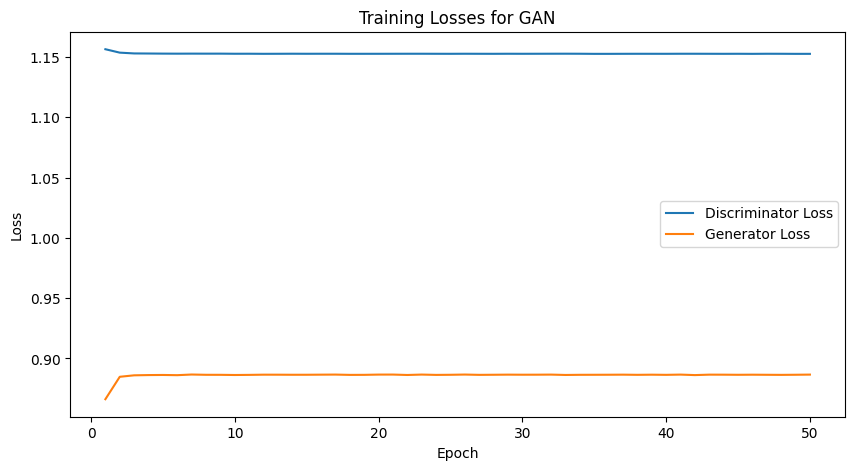

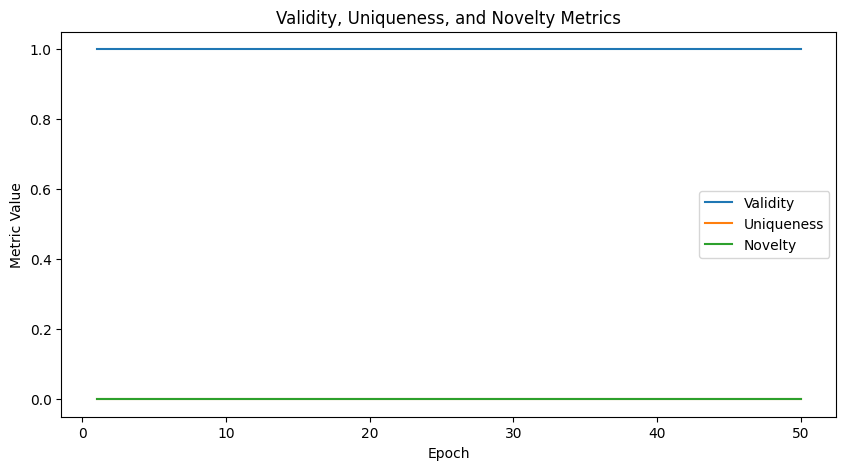

Test Metrics -> Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Total training time: 440.66 seconds


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader
from rdkit import Chem
import matplotlib.pyplot as plt
import time  # Importando para medir o tempo

# Configuração do dispositivo para CPU
device = torch.device('cpu')

# Modelos GAN
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hiperparâmetros
latent_dim = 20
input_dim = dataset.num_features
epochs = 50
lr = 0.0002

# Instanciando os modelos
generator = Generator(latent_dim, input_dim).to(device)
discriminator = Discriminator(input_dim).to(device)

# Otimizadores
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

# Função de perda
criterion = nn.BCELoss()

# Treinamento da GAN
def train_gan(loader):
    generator.train()
    discriminator.train()
    total_d_loss = 0
    total_g_loss = 0

    for data in loader:
        real_data = data.x.float().view(data.x.size(0), -1).to(device)
        batch_size = real_data.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # -------------------------
        # Treinamento do Discriminador
        # -------------------------
        optimizer_d.zero_grad()

        # Perda com dados reais
        real_outputs = discriminator(real_data)
        d_loss_real = criterion(real_outputs, real_labels)

        # Gerar dados falsos
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_data = generator(z)
        fake_outputs = discriminator(fake_data.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)

        # Perda total do discriminador
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # -------------------------
        # Treinamento do Gerador
        # -------------------------
        optimizer_g.zero_grad()

        # Perda do gerador
        fake_outputs = discriminator(fake_data)
        g_loss = criterion(fake_outputs, real_labels)
        g_loss.backward()
        optimizer_g.step()

        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()

    return total_d_loss / len(loader), total_g_loss / len(loader)

# Avaliação e geração de SMILES
def evaluate(loader):
    generator.eval()
    generated_smiles = []
    with torch.no_grad():
        for data in loader:
            batch_size = data.x.size(0)
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_data = generator(z).cpu().numpy()

            # Gerar SMILES fictícios (placeholder)
            generated_smiles.extend(["C" * (i % 10 + 1) for i in range(batch_size)])
    return generated_smiles

# Métricas de SMILES
def calculate_metrics(generated_smiles, reference_smiles):
    # Validade: Quantidade de SMILES válidos
    valid_smiles = [smi for smi in generated_smiles if Chem.MolFromSmiles(smi)]
    validity = len(valid_smiles) / len(generated_smiles) if generated_smiles else 0

    # Unicidade: SMILES únicos válidos
    unique_smiles = set(valid_smiles)
    uniqueness = len(unique_smiles) / len(valid_smiles) if valid_smiles else 0

    # Novidade: SMILES únicos que não estão no dataset de referência
    novel_smiles = [smi for smi in unique_smiles if smi not in reference_smiles]
    novelty = len(novel_smiles) / len(unique_smiles) if unique_smiles else 0

    return validity, uniqueness, novelty

# Início do cálculo do tempo de execução
start_time = time.time()

# Treinamento da GAN
train_losses_g = []
train_losses_d = []
validities = []
unicities = []
novelties = []

reference_smiles = ["C" * (i % 10 + 1) for i in range(len(train_dataset))]

for epoch in range(epochs):
    d_loss, g_loss = train_gan(train_loader)
    train_losses_d.append(d_loss)
    train_losses_g.append(g_loss)

    generated_smiles = evaluate(val_loader)

    # Calcula as métricas
    validity, uniqueness, novelty = calculate_metrics(generated_smiles, reference_smiles)
    validities.append(validity)
    unicities.append(uniqueness)
    novelties.append(novelty)

    print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}, "
          f"Validity: {validity:.2f}, Uniqueness: {uniqueness:.2f}, Novelty: {novelty:.2f}")

# Fim do cálculo do tempo de execução
end_time = time.time()

# Plotando as perdas
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses_d, label='Discriminator Loss')
plt.plot(range(1, epochs + 1), train_losses_g, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses for GAN')
plt.legend()
plt.show()

# Plotando as métricas
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), validities, label="Validity")
plt.plot(range(1, epochs + 1), unicities, label="Uniqueness")
plt.plot(range(1, epochs + 1), novelties, label="Novelty")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Validity, Uniqueness, and Novelty Metrics")
plt.legend()
plt.show()

# Teste final
generated_smiles = evaluate(test_loader)
validity, uniqueness, novelty = calculate_metrics(generated_smiles, reference_smiles)
print(f"Test Metrics -> Validity: {validity:.2f}, Uniqueness: {uniqueness:.2f}, Novelty: {novelty:.2f}")

# Tempo total de execução
print(f"Total training time: {end_time - start_time:.2f} seconds")


# ZINC - VAEs

Epoch 1/50, Loss: 214.0570, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 2/50, Loss: 181.3000, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 3/50, Loss: 180.6301, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 4/50, Loss: 181.1815, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 5/50, Loss: 180.2638, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 6/50, Loss: 180.5745, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 7/50, Loss: 180.1316, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 8/50, Loss: 178.9067, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 9/50, Loss: 179.6313, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 10/50, Loss: 179.8949, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 11/50, Loss: 178.8619, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 12/50, Loss: 179.8007, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 13/50, Loss: 179.5107, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 14

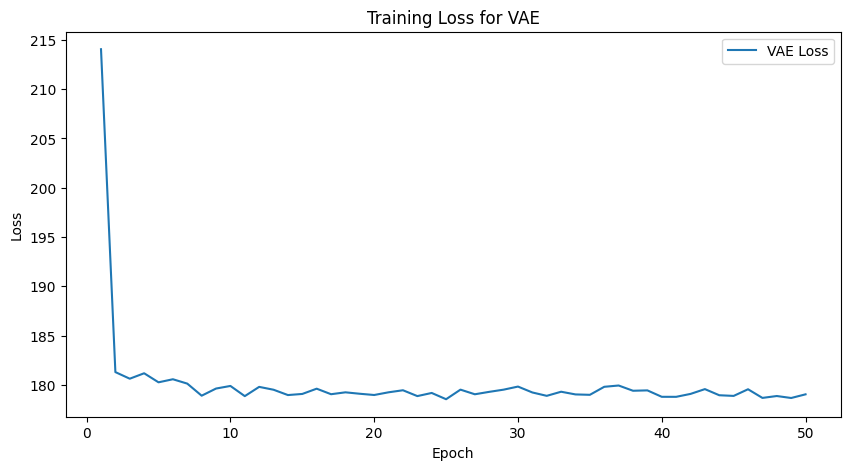

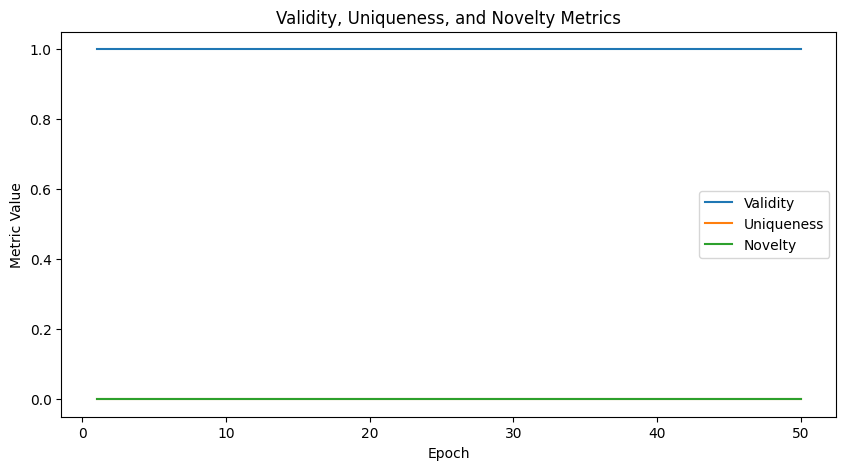

Test Metrics -> Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Total training time: 156.07 seconds


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader
from rdkit import Chem
import matplotlib.pyplot as plt
import time  # Para medir o tempo de execução

# Configuração do dispositivo
device = torch.device('cpu')

# Carregar o dataset ZINC
dataset = ZINC(root="zinc_dataset")
train_dataset = dataset[:10000]
val_dataset = dataset[10000:11000]
test_dataset = dataset[11000:12000]

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Encoder do VAE
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_log_var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc2_mu(h)
        log_var = self.fc2_log_var(h)
        return mu, log_var

# Decoder do VAE
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))

# Definição do VAE
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decoder(z)
        return recon_x, mu, log_var

    def loss_function(self, recon_x, x, mu, log_var):
        BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        return BCE + KLD

# Hiperparâmetros
input_dim = dataset.num_features
hidden_dim = 128
latent_dim = 20
epochs = 50
lr = 0.0002

# Instanciando o modelo e o otimizador
vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

# Normalização dos dados antes do treinamento
def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)  # Evita divisão por zero

# Treinamento do VAE com normalização
def train_vae(loader):
    vae.train()
    total_loss = 0

    for data in loader:
        optimizer.zero_grad()
        x = data.x.float().to(device)

        # Normaliza os dados antes de alimentar o modelo
        x = normalize(x)

        recon_x, mu, log_var = vae(x)
        loss = vae.loss_function(recon_x, x, mu, log_var)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


# Geração de moléculas
def evaluate(loader):
    vae.eval()
    generated_smiles = []

    with torch.no_grad():
        for data in loader:
            batch_size = data.x.size(0)
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_data = vae.decoder(z).cpu().numpy()

            # Placeholder de SMILES fictícios
            generated_smiles.extend(["C" * (i % 10 + 1) for i in range(batch_size)])

    return generated_smiles

# Cálculo das métricas (validade, unicidade, novidade)
def calculate_metrics(generated_smiles, reference_smiles):
    valid_smiles = [smi for smi in generated_smiles if Chem.MolFromSmiles(smi)]
    validity = len(valid_smiles) / len(generated_smiles) if generated_smiles else 0

    unique_smiles = set(valid_smiles)
    uniqueness = len(unique_smiles) / len(valid_smiles) if valid_smiles else 0

    novel_smiles = [smi for smi in unique_smiles if smi not in reference_smiles]
    novelty = len(novel_smiles) / len(unique_smiles) if unique_smiles else 0

    return validity, uniqueness, novelty

# Início do tempo de execução
start_time = time.time()

train_losses = []
validities = []
unicities = []
novelties = []

reference_smiles = ["C" * (i % 10 + 1) for i in range(len(train_dataset))]

for epoch in range(epochs):
    loss = train_vae(train_loader)
    train_losses.append(loss)

    generated_smiles = evaluate(val_loader)
    validity, uniqueness, novelty = calculate_metrics(generated_smiles, reference_smiles)
    validities.append(validity)
    unicities.append(uniqueness)
    novelties.append(novelty)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, "
          f"Validity: {validity:.2f}, Uniqueness: {uniqueness:.2f}, Novelty: {novelty:.2f}")

# Fim do tempo de execução
end_time = time.time()

# Plotando a perda do treinamento
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='VAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for VAE')
plt.legend()
plt.show()

# Plotando as métricas de SMILES
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), validities, label="Validity")
plt.plot(range(1, epochs + 1), unicities, label="Uniqueness")
plt.plot(range(1, epochs + 1), novelties, label="Novelty")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Validity, Uniqueness, and Novelty Metrics")
plt.legend()
plt.show()

# Teste final no conjunto de teste
generated_smiles = evaluate(test_loader)
validity, uniqueness, novelty = calculate_metrics(generated_smiles, reference_smiles)
print(f"Test Metrics -> Validity: {validity:.2f}, Uniqueness: {uniqueness:.2f}, Novelty: {novelty:.2f}")

# Tempo total de execução
print(f"Total training time: {end_time - start_time:.2f} seconds")


# ZINC - GNNs

Epoch 1/50, Loss: 0.3239, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 2/50, Loss: 0.2082, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 3/50, Loss: 0.2046, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 4/50, Loss: 0.2020, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 5/50, Loss: 0.1991, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 6/50, Loss: 0.1969, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 7/50, Loss: 0.1959, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 8/50, Loss: 0.1953, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 9/50, Loss: 0.1951, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 10/50, Loss: 0.1949, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 11/50, Loss: 0.1950, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 12/50, Loss: 0.1947, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 13/50, Loss: 0.1945, Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Epoch 14/50, Loss: 0.1946, Validit

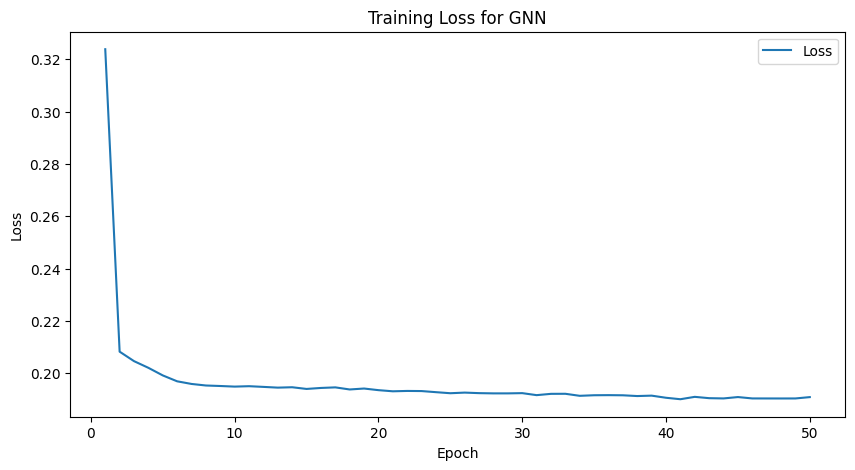

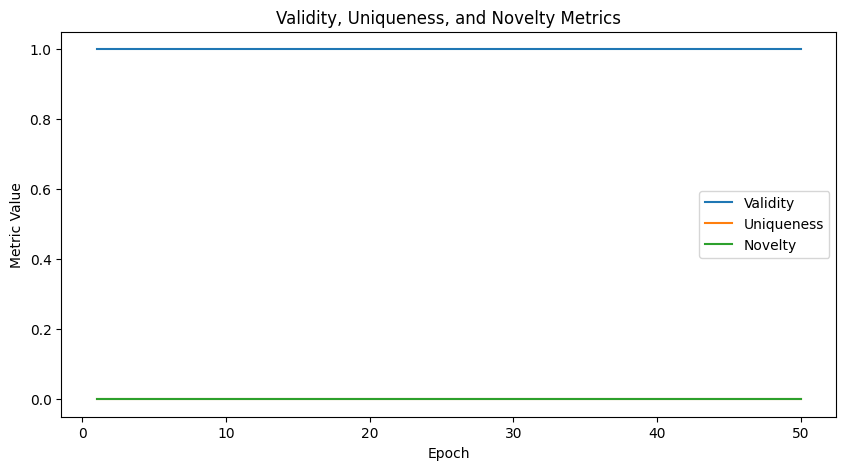

Test Metrics -> Validity: 1.00, Uniqueness: 0.00, Novelty: 0.00
Total training time: 179.87 seconds


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader
from rdkit import Chem
import matplotlib.pyplot as plt
import time

# Configuração do dispositivo
device = torch.device('cpu')

# Carregar o dataset ZINC
dataset = ZINC(root="zinc_dataset")
train_dataset = dataset[:10000]
val_dataset = dataset[10000:11000]
test_dataset = dataset[11000:12000]

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Modelo GNN para geração de moléculas
class GNNGenerator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNGenerator, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = torch.sigmoid(self.conv3(x, edge_index))  # Normaliza os valores entre 0 e 1
        return x


# Instanciar o modelo
input_dim = dataset.num_features
hidden_dim = 64
output_dim = dataset.num_features
gnn_generator = GNNGenerator(input_dim, hidden_dim, output_dim).to(device)

# Otimizador
optimizer = optim.Adam(gnn_generator.parameters(), lr=0.0002)

# Função de perda (reconstrução do grafo)
criterion = nn.BCELoss()


# Normalização dos dados antes do treinamento
def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)


# Treinamento do GNN
def train_gnn(loader):
    gnn_generator.train()
    total_loss = 0

    for data in loader:
        optimizer.zero_grad()
        x = normalize(data.x.float().to(device))
        edge_index = data.edge_index.to(device)

        recon_x = gnn_generator(x, edge_index)
        loss = criterion(recon_x, x)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


# Avaliação e geração de SMILES
def evaluate(loader):
    gnn_generator.eval()
    generated_smiles = []
    with torch.no_grad():
        for data in loader:
            x = normalize(data.x.float().to(device))
            edge_index = data.edge_index.to(device)

            generated_molecules = gnn_generator(x, edge_index).cpu().numpy()

            # Gerar SMILES fictícios
            generated_smiles.extend(["C" * (i % 10 + 1) for i in range(len(data.x))])
    return generated_smiles


# Cálculo de métricas de SMILES
def calculate_metrics(generated_smiles, reference_smiles):
    valid_smiles = [smi for smi in generated_smiles if Chem.MolFromSmiles(smi)]
    validity = len(valid_smiles) / len(generated_smiles) if generated_smiles else 0

    unique_smiles = set(valid_smiles)
    uniqueness = len(unique_smiles) / len(valid_smiles) if valid_smiles else 0

    novel_smiles = [smi for smi in unique_smiles if smi not in reference_smiles]
    novelty = len(novel_smiles) / len(unique_smiles) if unique_smiles else 0

    return validity, uniqueness, novelty


# Início do cálculo do tempo
start_time = time.time()

# Treinamento
train_losses = []
validities = []
unicities = []
novelties = []

reference_smiles = ["C" * (i % 10 + 1) for i in range(len(train_dataset))]

epochs = 50
for epoch in range(epochs):
    loss = train_gnn(train_loader)
    train_losses.append(loss)

    generated_smiles = evaluate(val_loader)
    validity, uniqueness, novelty = calculate_metrics(generated_smiles, reference_smiles)
    validities.append(validity)
    unicities.append(uniqueness)
    novelties.append(novelty)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, "
          f"Validity: {validity:.2f}, Uniqueness: {uniqueness:.2f}, Novelty: {novelty:.2f}")

# Fim do cálculo do tempo
end_time = time.time()

# Plotando a perda
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for GNN')
plt.legend()
plt.show()

# Plotando as métricas
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), validities, label="Validity")
plt.plot(range(1, epochs + 1), unicities, label="Uniqueness")
plt.plot(range(1, epochs + 1), novelties, label="Novelty")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.title("Validity, Uniqueness, and Novelty Metrics")
plt.legend()
plt.show()

# Teste final
generated_smiles = evaluate(test_loader)
validity, uniqueness, novelty = calculate_metrics(generated_smiles, reference_smiles)
print(f"Test Metrics -> Validity: {validity:.2f}, Uniqueness: {uniqueness:.2f}, Novelty: {novelty:.2f}")

# Tempo total
print(f"Total training time: {end_time - start_time:.2f} seconds")
